In [1]:
import numpy as np
import pandas as pd
import math
import torch
import config as cfg
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from utility.survival import Survival
from tools.regressors import CoxPH, RSF, DeepSurv, DSM, BNNmcd
from tools.feature_selectors import PHSelector
from utility.builder import Builder
from tools.file_reader import FileReader
from tools.data_ETL import DataETL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lifelines.statistics import proportional_hazard_test
from tools.evaluator import LifelinesEvaluator
from tools.Evaluations.util import predict_median_survival_time
import config as cfg
from sklearn.preprocessing import StandardScaler
from tools.formatter import Formatter
from xgbse.non_parametric import calculate_kaplan_vectorized
from utility.survival import make_event_times

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)

plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

global DATASET
global N_BEARING
global TEST_SIZE
global TRAIN_SIZE
global N_SPLITS
global N_CONDITION
global TYPE
global MERGE
global CENSORING
global N_BOOT

NEW_DATASET = False
DATASET = "xjtu"
TYPE = "correlated"  # not_correlated
CONDITION_SELECTOR = 0 # 0, 1, 2
PERCENTAGE = 0.1
TEST_SIZE = 0.3
N_POST_SAMPLES = 1000 # number of samples to draw from MCD posterior
N_CONDITION = len(cfg.RAW_DATA_PATH_XJTU)
PLOTS_PATH = cfg.PLOTS_PATH

if TYPE == "bootstrap":
    N_BOOT = 8
    cfg.DATA_TYPE = "bootstrap"
else:
    N_BOOT = 3
    cfg.DATA_TYPE = "not_bootstrap"

data_path = cfg.RAW_DATA_PATH_XJTU
N_CONDITION = len(data_path)
N_BEARING = cfg.N_REAL_BEARING_XJTU
N_SPLITS = 5
TRAIN_SIZE = 1
CENSORING = cfg.CENSORING_LEVEL

In [2]:
#For the first time running, a NEW_DATASET is needed
if NEW_DATASET== True:
    Builder(DATASET, N_BOOT).build_new_dataset(bootstrap=N_BOOT)

survival = Survival()
data_util = DataETL(DATASET, N_BOOT)

#Extract information from the dataset selected from the config file
cov_group = []
boot_group = []
info_group = []
for test_cond in range (0, N_CONDITION):
    cov, boot, info_pack = FileReader(DATASET).read_data(test_cond, N_BOOT)
    cov_group.append(cov)
    boot_group.append(boot)
    info_group.append(info_pack)

#Transform information from the dataset selected from the config file
data_container_X = []
data_container_y= []
for test_cond, (cov, boot, info_pack) in enumerate(zip(cov_group, boot_group, info_group)):
    # Create different data for bootstrap and not bootstrap
    if TYPE == "bootstrap":
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_bootstrap(cov, boot, info_pack, N_BOOT)
    else:
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_upsampling(cov, boot, info_pack, N_BOOT, TYPE)
    data_container_X.append(data_temp_X)
    data_container_y.append(deltaref_temp_y)

FileNotFoundError: [Errno 2] No such file or directory: './data/XJTU-SY/csv/covariates_0.csv'

In [ ]:
X = data_container_X[CONDITION_SELECTOR]
n_censored = X.shape[0] - X["Event"].sum()
print ("There are {} samples censored from a total of {} samples".format(n_censored, X.shape[0]))
print("%.1f%% of records are censored" % (n_censored / X.shape[0] * 100))

val, bins, patches = plt.hist((X["Survival_time"][X["Event"]],
                                X["Survival_time"][~X["Event"]]),
                                bins=200, stacked=True)
_ = plt.legend(patches, ["Censoring Time", "Event Time"])
plt.xlabel("Time (min)")
plt.ylabel("Number of occurrences")
plt.figure(figsize=(9, 6))

The event detector established an event for each bearing at: {1: 70.0, 11: 50.0, 21: 130.0, 31: 60.0, 41: 40.0}


 44%|████▍     | 44/100 [00:01<00:01, 32.38it/s]


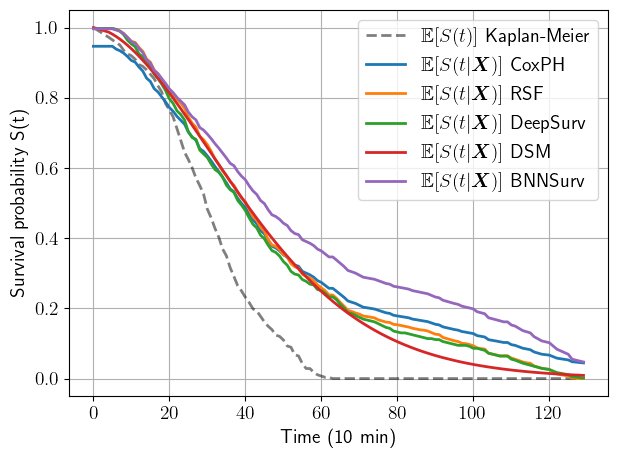

In [3]:
#Load information from the dataset selected in the config file
X = data_container_X[CONDITION_SELECTOR]
y = data_container_y[CONDITION_SELECTOR]

#Information about the event estimation in event detector
y_delta = y
print ("The event detector established an event for each bearing at:", y_delta)

data_X = []
for data_group in X:   
    data_temp_X = Formatter.control_censored_data(data_group, percentage=PERCENTAGE)
    data_X.append(data_temp_X)
X = data_X

#Indexing the dataset to avoid train/test leaking
bearing_idx = list(range(0, N_BEARING))

#Test/train split
train_idx, test_idx, _, _= train_test_split(bearing_idx, bearing_idx, shuffle=False, test_size=TEST_SIZE, random_state=0)
data_X_merge_tr = pd.DataFrame()
data_X_merge_te = pd.DataFrame()
for element in train_idx:
    data_X_merge_tr = pd.concat([data_X_merge_tr, X[element]], ignore_index=True)
for element in test_idx:
    data_X_merge_te = pd.concat([data_X_merge_te, X[element]], ignore_index=True)
    
# Format data
X_train = data_X_merge_tr.drop(['Event', 'Survival_time'], axis=1)
X_test = data_X_merge_te.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", data_X_merge_tr)
y_test = Surv.from_dataframe("Event", "Survival_time", data_X_merge_te)
features = list(X_train.columns)

#Set event times for models
event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
event_times = np.unique(event_times)

#Set the feature selector and train/test split
best_features = PHSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()
X_train, X_test = X_train.loc[:,best_features], X_test.loc[:,best_features]

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Format the data for NN models
t_train = y_train['Survival_time']
e_train = y_train['Event']
t_test = y_test['Survival_time']
e_test = y_test['Event']

#Make models
cph_model = CoxPH().make_model(CoxPH().get_best_hyperparams())
rsf_model = RSF().make_model(RSF().get_best_hyperparams())
deep_surv_model = DeepSurv().make_model(DeepSurv().get_best_hyperparams())
dsm_model = DSM().make_model(DSM().get_best_hyperparams())
bnn_model = BNNmcd().make_model(BNNmcd().get_best_hyperparams())

#Train model
deepsurv_params = DeepSurv().get_best_hyperparams()
dsm_params = DSM().get_best_hyperparams()
cph_model.fit(X_train_scaled, y_train)
rsf_model.fit(X_train_scaled, y_train)
deep_surv_model.fit(X_train_scaled, t_train, e_train, vsize=0.3,
                    iters=deepsurv_params['iters'],
                    learning_rate=deepsurv_params['learning_rate'],
                    batch_size=deepsurv_params['batch_size'])
dsm_model.fit(X_train_scaled, t_train, e_train, vsize=0.3,
              iters=dsm_params['iters'],
              learning_rate=dsm_params['learning_rate'],
              batch_size=dsm_params['batch_size'])
bnn_model.fit(X_train_scaled, t_train, e_train)

#Predict
cph_surv_func = survival.predict_survival_function(cph_model, X_test_scaled, event_times)
rsf_surv_func = survival.predict_survival_function(rsf_model, X_test_scaled, event_times)
deep_surv_surv_func = survival.predict_survival_function(deep_surv_model, X_test_scaled, event_times)
dsm_surv_func = survival.predict_survival_function(dsm_model, X_test_scaled, event_times)
bnn_surv_func = survival.predict_survival_function(bnn_model, X_test_scaled, event_times,
                                                   n_post_samples=N_POST_SAMPLES)
km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Survival_time'].reshape(1,-1),
                                                       y_test['Event'].reshape(1,-1),
                                                       event_times)

#plt.figure(figsize=(6, 4))
plt.plot(km_mean.columns, km_mean.iloc[0], 'k--', linewidth=2, alpha=0.5, label=r"$\mathbb{E}[S(t)]$ Kaplan-Meier", color="black")
plt.plot(event_times, np.mean(cph_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ CoxPH", color="C0", linewidth=2)
plt.plot(event_times, np.mean(rsf_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ RSF", color="C1", linewidth=2)
plt.plot(event_times, np.mean(deep_surv_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ DeepSurv", color="C2", linewidth=2)
plt.plot(event_times, np.mean(dsm_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ DSM", color="C3", linewidth=2)
plt.plot(event_times, np.mean(bnn_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ BNNSurv", color="C4", linewidth=2)
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability S(t)")
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig(f'{PLOTS_PATH}/mean_survival_cond_{CONDITION_SELECTOR}.pdf',
            format='pdf', bbox_inches="tight")

The event detector established an event for each bearing at: {1: 70.0, 11: 50.0, 21: 130.0, 31: 60.0, 41: 40.0}


100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


100%|██████████| 1/1 [00:00<00:00, 166.62it/s]


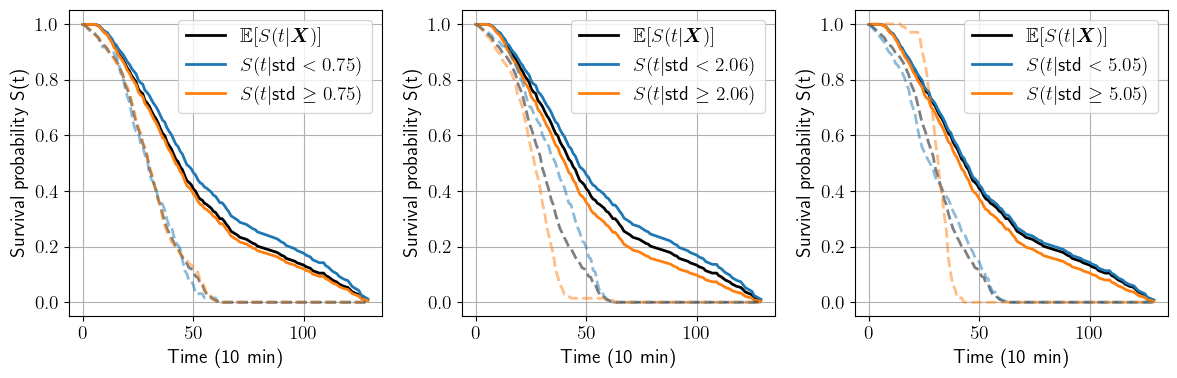

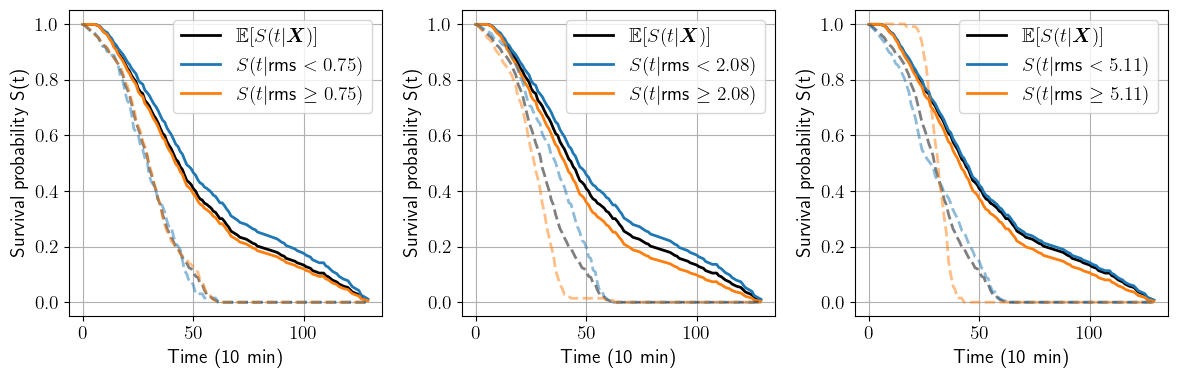

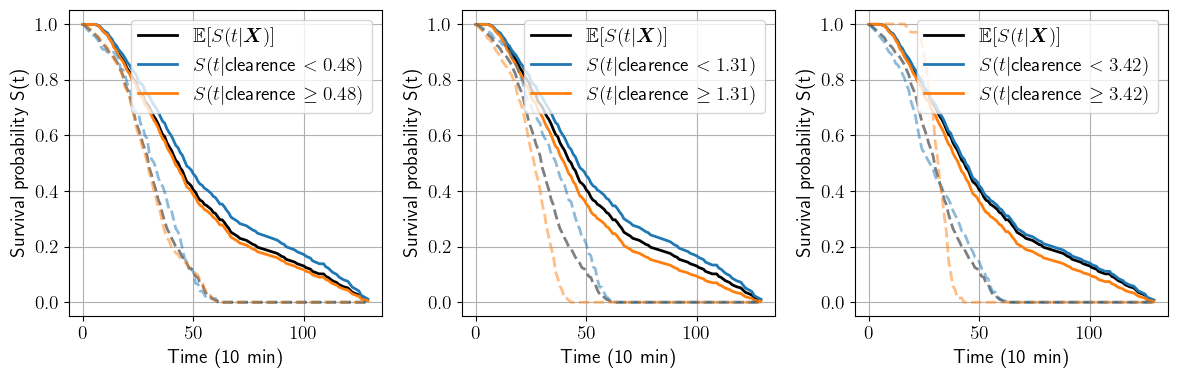

In [4]:
#Load information from the dataset selected in the config file
X = data_container_X[CONDITION_SELECTOR]
y = data_container_y[CONDITION_SELECTOR]

#Information about the event estimation in event detector
y_delta = y
print ("The event detector established an event for each bearing at:", y_delta)

data_X = []
for data_group in X:   
    data_temp_X = Formatter.control_censored_data(data_group, percentage=PERCENTAGE)
    data_X.append(data_temp_X)
X = data_X

#Indexing the dataset to avoid train/test leaking
bearing_idx = list(range(0, N_BEARING))

#Test/train split
train_idx, test_idx, _, _= train_test_split(bearing_idx, bearing_idx, shuffle=False, test_size=TEST_SIZE, random_state=0)
data_X_merge_tr = pd.DataFrame()
data_X_merge_te = pd.DataFrame()
for element in train_idx:
    data_X_merge_tr = pd.concat([data_X_merge_tr, X[element]], ignore_index=True)
for element in test_idx:
    data_X_merge_te = pd.concat([data_X_merge_te, X[element]], ignore_index=True)
    
# Format data
X_train = data_X_merge_tr.drop(['Event', 'Survival_time'], axis=1)
X_test = data_X_merge_te.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", data_X_merge_tr)
y_test = Surv.from_dataframe("Event", "Survival_time", data_X_merge_te)
features = list(X_train.columns)

#Set event times for models
event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
event_times = np.unique(event_times)

#Set the feature selector and train/test split
best_features = PHSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()

#Format the data for NNs models
t_train = y_train['Survival_time']
e_train = y_train['Event']
t_test = y_test['Survival_time']
e_test = y_test['Event']

# Split data
features_to_split = best_features
for feature in features_to_split:
    X_train_feature, X_test_feature = pd.DataFrame(X_train[feature]), pd.DataFrame(X_test[feature])

    # Scale train data
    scaler = StandardScaler()
    scaler.fit(X_train_feature)
    X_train_scaled = scaler.transform(X_train_feature)

    #model.fit(X_train, y_train)
    #model = BNNmcd().make_model(BNNmcd().get_best_hyperparams())
    model = DeepSurv().make_model(DeepSurv().get_best_hyperparams())
    model.fit(X_train_scaled, t_train, e_train)
    split_thresholds = []
    for qct in [0.25, 0.5, 0.75]:
        split_thresholds.append(round(X_test_feature[feature].quantile(qct), 2))
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, st in enumerate(split_thresholds):
        g1_idx = X_test_feature.loc[X_test_feature[feature] < st].index
        g2_idx = X_test_feature.loc[X_test_feature[feature] >= st].index
        X_test_g1 = X_test_feature.loc[g1_idx]
        X_test_g2 = X_test_feature.loc[g2_idx]
        y_test_g1 = y_test[g1_idx]
        y_test_g2 = y_test[g2_idx]

        # Scale splitted data
        X_test_scaled = scaler.transform(X_test_feature)
        X_test_g1_scaled = scaler.transform(X_test_g1)
        X_test_g2_scaled = scaler.transform(X_test_g2)

        # Predict for mean and two groups
        surv_probs = survival.predict_survival_function(model, X_test_scaled, event_times,
                                                        n_post_samples=N_POST_SAMPLES)
        km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Survival_time'].reshape(1,-1),
                                                               y_test['Event'].reshape(1,-1),
                                                               event_times)
        surv_probs_g1 = survival.predict_survival_function(model, X_test_g1_scaled, event_times,
                                                           n_post_samples=N_POST_SAMPLES)
        km_mean_g1, km_high_g1, km_low_g1 = calculate_kaplan_vectorized(y_test_g1['Survival_time'].reshape(1,-1),
                                                                        y_test_g1['Event'].reshape(1,-1),
                                                                        event_times)
        surv_probs_g2 = survival.predict_survival_function(model, X_test_g2_scaled, event_times,
                                                           n_post_samples=N_POST_SAMPLES)
        km_mean_g2, km_high_g2, km_low_g2 = calculate_kaplan_vectorized(y_test_g2['Survival_time'].reshape(1,-1),
                                                                        y_test_g2['Event'].reshape(1,-1),
                                                                        event_times)
        surv_probs_mean = np.mean(surv_probs, axis=0)
        surv_probs_g1_mean = np.mean(surv_probs_g1, axis=0)
        surv_probs_g2_mean = np.mean(surv_probs_g2, axis=0)
        
        # Plot
        axes[i].plot(surv_probs_mean, linewidth=2, label=r"$\mathbb{E}[S(t|\bm{X})]$", color="black")
        axes[i].plot(surv_probs_g1_mean, linewidth=2, label=r"$S(t|$" + f"{feature} $<{st})$", color="C0")
        axes[i].plot(surv_probs_g2_mean, linewidth=2, label=r"$S(t|$" + f"{feature} $\geq{st})$", color="C1")
        axes[i].plot(km_mean.columns, km_mean.iloc[0], 'k--', linewidth=2, alpha=0.5, color="black")
        axes[i].plot(km_mean_g1.columns, km_mean_g1.iloc[0], 'k--', linewidth=2, alpha=0.5, color="C0")
        axes[i].plot(km_mean_g2.columns, km_mean_g2.iloc[0], 'k--', linewidth=2, alpha=0.5, color="C1")
        axes[i].set_xlabel("Time (10 min)")
        axes[i].set_ylabel("Survival probability S(t)")
        axes[i].legend(loc='upper right')
        axes[i].grid(True)
        fig.tight_layout()
        fig.show()
    plt.savefig(f'{PLOTS_PATH}/group_{feature}_survival_cond_{CONDITION_SELECTOR}.pdf',
                format='pdf', bbox_inches="tight")

In [5]:
X_test_g1

,clearence
0,0.577082
1,0.746091
2,0.577082
3,0.746091
4,0.823325
...,...
395,2.766827
396,2.548918
397,1.409873
398,2.548918


In [6]:
X_test_g2

,clearence
201,6.593997
202,6.167295
203,7.549585
204,6.167295
205,7.549585
...,...
316,3.501947
318,3.501947
319,3.794468
329,3.698635


{1: 70.0, 11: 50.0, 21: 130.0, 31: 60.0, 41: 40.0}
{1: 359.6, 11: 137.3, 21: 275.6, 31: 20.0, 41: 190.0}
{1: 1010.0, 11: 1708.8, 21: 330.0, 31: 507.9, 41: 20.0}


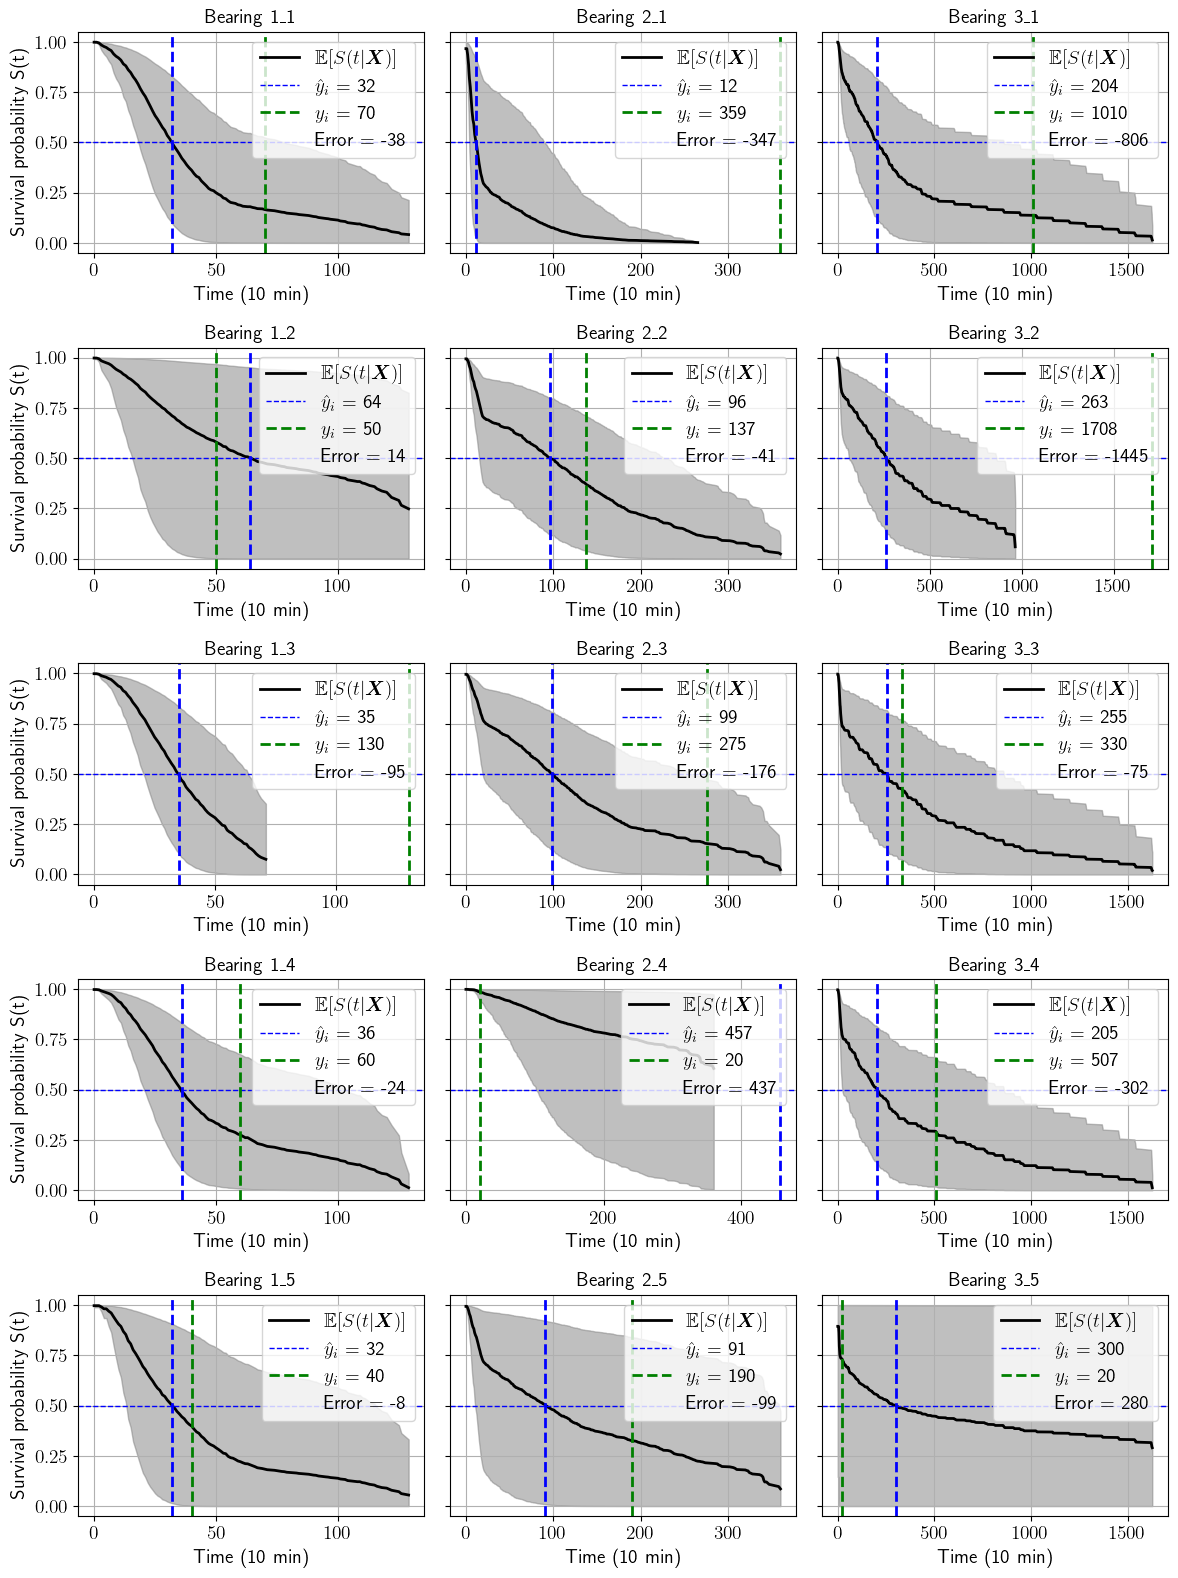

In [10]:
from matplotlib.patches import Rectangle
N_POST_SAMPLES = 1000

fig, axes = plt.subplots(5, 3, figsize=(12, 16), sharey=True)
for cond in [0, 1, 2]:
    # Load data
    X = data_container_X[cond]
    y = data_container_y[cond]
    print(y)

    data_X = []
    for data_group in X:   
        data_temp_X = Formatter.control_censored_data(data_group, percentage=PERCENTAGE)
        data_X.append(data_temp_X)
    X = data_X

    # Individual bearing prediction
    bearings = np.arange(0, N_BEARING)
    for idx in bearings:
        train_idx = bearings[np.arange(len(bearings))!=idx]
        test_idx = bearings[idx]
        
        X_train_merged = pd.DataFrame()
        for element in train_idx:
            X_train_merged = pd.concat([X_train_merged, X[element]], ignore_index=True)
        X_test_merged = pd.DataFrame(X[test_idx])
        
        # Select only first observation
        X_test_merged = X_test_merged[X_test_merged['Survival_time'] == X_test_merged['Survival_time'].max()] \
                        .drop_duplicates(subset="Survival_time")
        
        # Format data
        X_train = X_train_merged.drop(['Event', 'Survival_time'], axis=1)
        X_test = X_test_merged.drop(['Event', 'Survival_time'], axis=1)
        y_train = Surv.from_dataframe("Event", "Survival_time", X_train_merged)
        y_test = Surv.from_dataframe("Event", "Survival_time", X_test_merged)
        failure_time = list(y.values())[idx]
        
        #Set event times for general models and only NNs
        event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
        event_times = np.unique(event_times)

        #Set the feature selector and train/test split
        best_features = PHSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()
        X_train, X_test = X_train.loc[:,best_features], X_test.loc[:,best_features]

        # Scale train data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        #Set up the models on test
        model = BNNmcd().make_model(BNNmcd().get_best_hyperparams())

        #Format the data for NNs models
        t_train = y_train['Survival_time']
        e_train = y_train['Event']
        t_test = y_test['Survival_time']
        e_test = y_test['Event']

        # Train the models and get the calculation time for each
        model.fit(X_train_scaled, t_train, e_train)
        
        # Predict
        surv_probs = model.predict_survival(X_test_scaled, event_times, N_POST_SAMPLES)
        median_outputs = pd.DataFrame(np.mean(surv_probs, axis=0), columns=event_times)
        
        # Calculate TTE
        lifelines_eval = LifelinesEvaluator(median_outputs.T, t_test, e_test, t_train, e_train)
        median_survival_time = round(np.median(lifelines_eval.predict_time_from_curve(predict_median_survival_time)))
        mae = lifelines_eval.mae(method="Hinge")
        
        # Plot
        p1 = axes[idx, cond].plot(np.mean(median_outputs, axis=0).T, linewidth=2, label=r"$\mathbb{E}[S(t|\bm{X})]$", color="black")
        drop_num = math.floor(0.5 * N_POST_SAMPLES * (1 - 0.9))
        lower_outputs = torch.kthvalue(torch.from_numpy(surv_probs), k=1+drop_num, dim=0)[0]
        upper_outputs = torch.kthvalue(torch.from_numpy(surv_probs), k=N_POST_SAMPLES-drop_num, dim=0)[0]
        axes[idx, cond].fill_between(event_times, upper_outputs[0,:], lower_outputs[0,:], color="gray", alpha=0.5)
        p2 = axes[idx, cond].axhline(y=0.5, linestyle= "dashed", color='blue', linewidth=1, label='$\hat{y}_{i}$ = ' + f'{median_survival_time}')        
        p3 = axes[idx, cond].axvline(x=failure_time, linestyle= "dashed",
                                     color='green', linewidth=2.0, label=f'$y_i$ = {int(failure_time)}')
        axes[idx, cond].axvline(x=int(median_survival_time), linestyle= "dashed", color='blue', linewidth=2.0)
        axes[idx, cond].set_title(f'Bearing {cond+1}_{idx+1}')
        axes[idx, cond].set_xlabel("Time (10 min)")
        text = f'Error = {int(median_survival_time-failure_time)}'
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        axes[idx, cond].legend([p1[0], p2, p3, extra], [p1[0].get_label(), p2.get_label(), p3.get_label(), text], loc='upper right')
        if cond == 0:
            axes[idx, cond].set_ylabel("Survival probability S(t)")
        axes[idx, cond].grid(True)
plt.tight_layout()
plt.savefig(f'{PLOTS_PATH}/indvidiual_survival_all_conds.pdf', format='pdf', bbox_inches="tight")


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1000 total observations, 100 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic      p  -log2(p)
clearence km              1.03   0.31      1.69
          rank            0.96   0.33      1.61
crest     km              7.63   0.01      7.44
          rank            7.89 <0.005      7.65
entropy   km             12.59 <0.005     11.33
          rank           13.07 <0.005     11.70
impulse   km              0.05   0.83      0.27
          rank            0.03   0.85      0.23
kurtosis  km             15.66 <0.005     13.68
          rank           15.06 <0.005     13.23
max       km              2.54   0.11      3.17
          rank            2.53   0.11      3.16
mean      km              0.87   0.35      1.51
          rank            0.86   0.35      1.49
p2p       km              0.20   0.65      0.62
          rank            0.26   0.61      0.71
rms       km              0.32   0.57      0.80
          rank            0.30   0.59      0.77
shape     km             31.91 <0.005     25.88
          rank           30.66 <0.005     24.96
skew      km              6.67   0.01      6.67
          rank            6.66   0.01      6.66
std       km              0.01   0.93      0.11
          rank            0.01   0.94      0.09



1. Variable 'skew' failed the non-proportional test: p-value is 0.0098.

   Advice 1: the functional form of the variable 'skew' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'skew' using pd.cut, and then specify it in `strata=['skew',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'kurtosis' failed the non-proportional test: p-value is 0.0001.

   Advice 1: the functional form of the variable 'kurtosis' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D

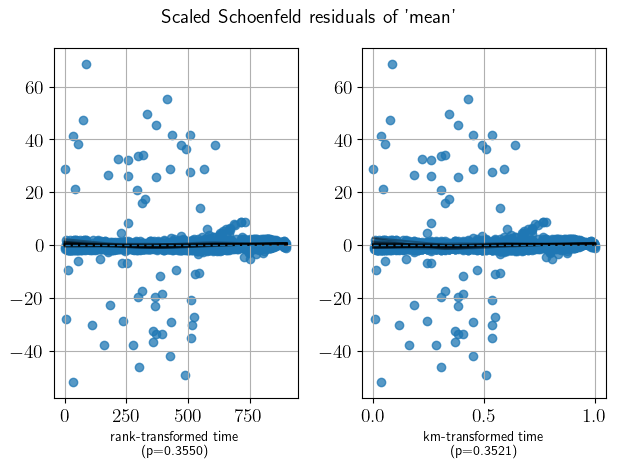

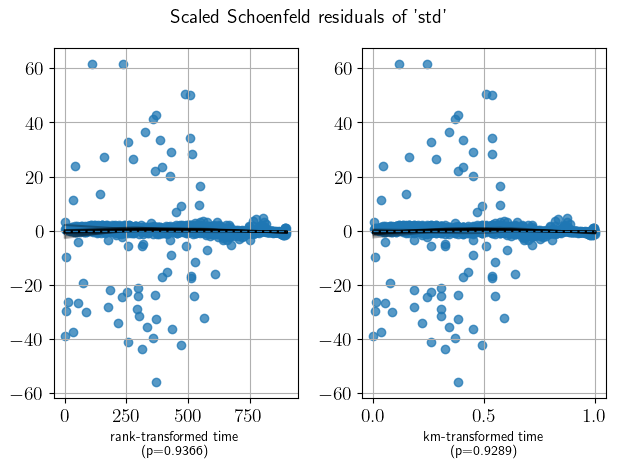

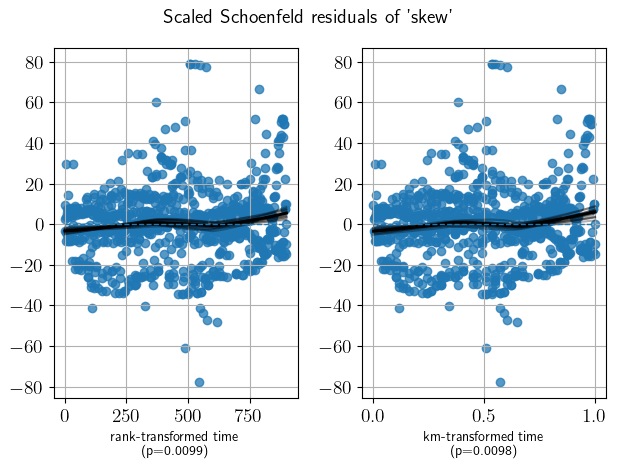

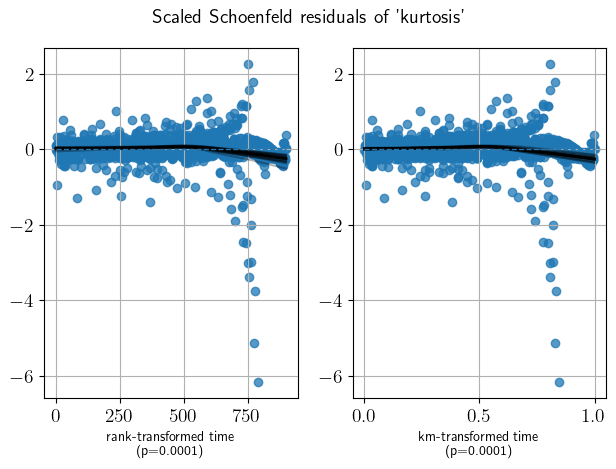

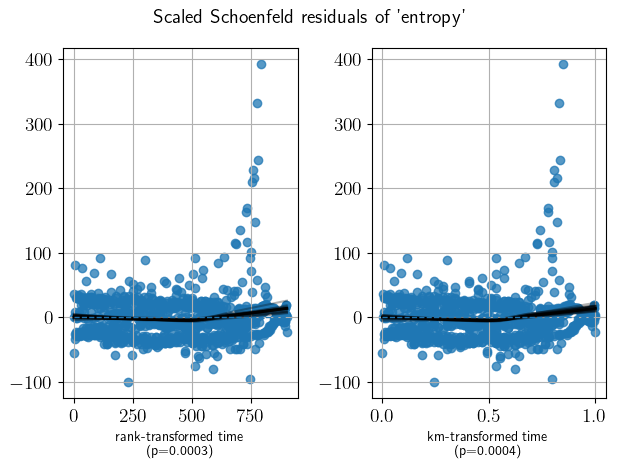

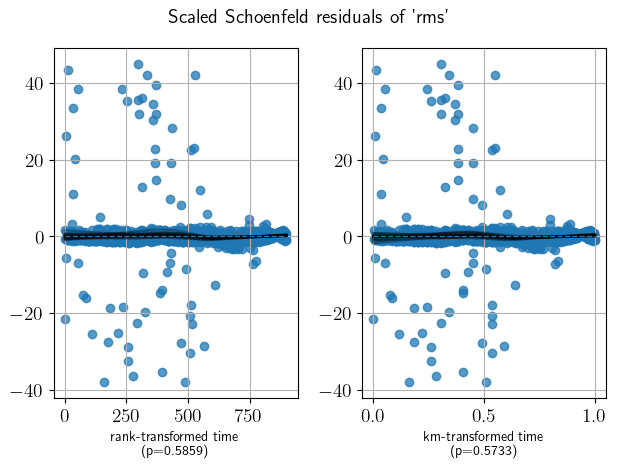

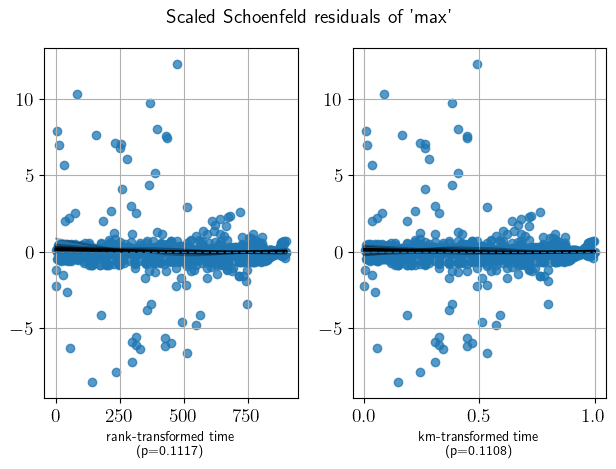

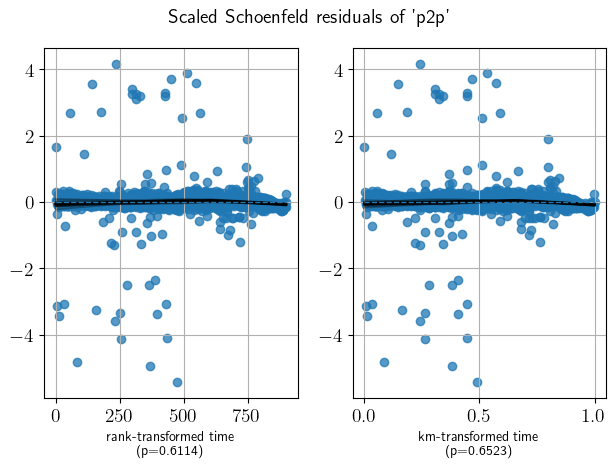

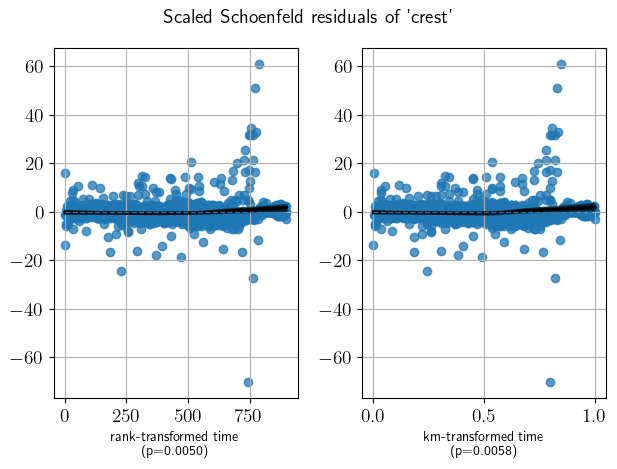

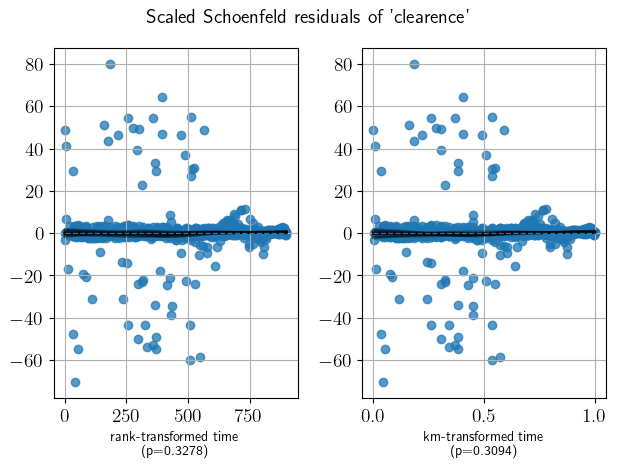

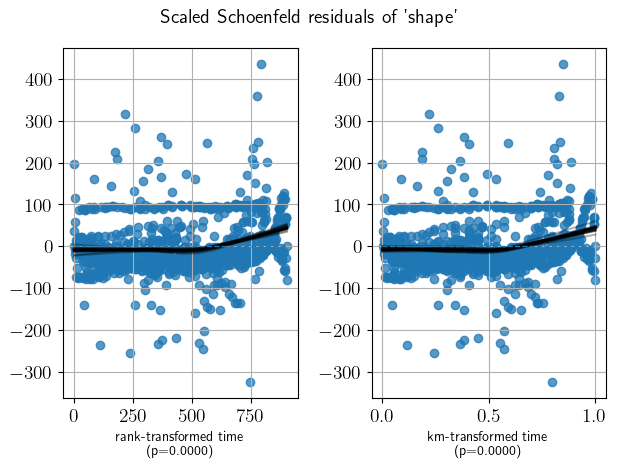

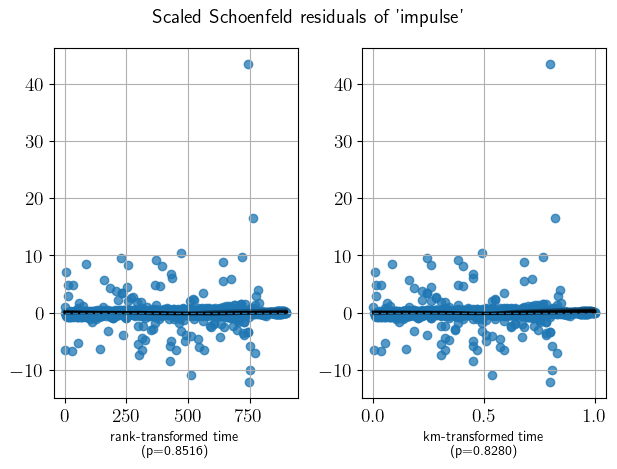

In [8]:
from lifelines import CoxPHFitter
from typing import List, Optional, Dict, Any, Iterable
from textwrap import dedent, fill
from autograd import numpy as anp
import numpy as np
from pandas import DataFrame, Series
from lifelines.statistics import proportional_hazard_test, TimeTransformers
from lifelines.utils import format_p_value
from lifelines.utils.lowess import lowess

cond = 0
X = data_container_X[cond][0].append(data_container_X[cond][1], ignore_index=True)
X = X.append(data_container_X[cond][2], ignore_index=True)
X = X.append(data_container_X[cond][3], ignore_index=True)
X = X.append(data_container_X[cond][4], ignore_index=True)
cph = CoxPHFitter() #penalizer= 0.0001
#X_spec = X[['std', 'rms', 'clearence', 'entropy', 'Event', 'Survival_time']]
X_spec = X.loc[:, ~X.columns.isin(['Fca','Fi','Fo','Fr','Frp','FoH', 'FiH', 'FrH', 'FrpH', 'FcaH', 'noise'])]
#X_spec = X[['mean', 'clearence', 'Event', 'Survival_time']]
cph.fit(X_spec, duration_col= "Survival_time", event_col= "Event")

# Compute and plot PH
training_df = X_spec
advice = True
show_plots = True
p_value_threshold = 0.05
plot_n_bootstraps = 15
columns = None
residuals = cph.compute_residuals(training_df, kind="scaled_schoenfeld")
test_results = proportional_hazard_test(cph, training_df, time_transform=["rank", "km"], precomputed_residuals=residuals)
residuals_and_duration = residuals.join(training_df[cph.duration_col])
Xs = cph.regressors.transform_df(training_df)
counter = 0
n = residuals_and_duration.shape[0]
axes = []
for variable in cph.params_.index.intersection(columns or cph.params_.index):
    minumum_observed_p_value = test_results.summary.loc[variable, "p"].min()
    
    # plot is done (regardless of test result) whenever `show_plots = True`
    if show_plots:
        axes.append([])
        print()
        print("   Bootstrapping lowess lines. May take a moment...")
        print()
        from matplotlib import pyplot as plt

        fig = plt.figure()

        # plot variable against all time transformations.
        for i, (transform_name, transformer) in enumerate(TimeTransformers().iter(["rank", "km"]), start=1):
            p_value = test_results.summary.loc[(variable, transform_name), "p"]

            ax = fig.add_subplot(1, 2, i)

            y = residuals_and_duration[variable]
            tt = transformer(cph.durations, cph.event_observed, cph.weights)[cph.event_observed.values]

            ax.scatter(tt, y, alpha=0.75)

            y_lowess = lowess(tt.values, y.values)
            ax.plot(tt, y_lowess, color="k", alpha=1.0, linewidth=2)

            # bootstrap some possible other lowess lines. This is an approximation of the 100% confidence intervals
            for _ in range(plot_n_bootstraps):
                ix = sorted(np.random.choice(n, n))
                tt_ = tt.values[ix]
                y_lowess = lowess(tt_, y.values[ix])
                ax.plot(tt_, y_lowess, color="k", alpha=0.30)

            best_xlim = ax.get_xlim()
            ax.hlines(0, 0, tt.max(), linestyles="dashed", linewidths=1)
            ax.set_xlim(best_xlim)

            ax.set_xlabel("%s-transformed time\n(p=%.4f)" % (transform_name, p_value), fontsize=10)
            ax.grid(True)
            axes[-1].append(ax)

        fig.suptitle("Scaled Schoenfeld residuals of '%s'" % variable, fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.savefig(f'{PLOTS_PATH}/ph_assump_cond_{cond}_{variable}.pdf', format='pdf', bbox_inches="tight")

    if np.round(minumum_observed_p_value, 2) > p_value_threshold:
        continue

    counter += 1

    if counter == 1:
        if advice:
            print(
                fill(
                    """The ``p_value_threshold`` is set at %g. Even under the null hypothesis of no violations, some covariates will be below the threshold by chance. This is compounded when there are many covariates. Similarly, when there are lots of observations, even minor deviances from the proportional hazard assumption will be flagged."""
                    % p_value_threshold,
                    width=100,
                )
            )
            print()
            print(
                fill(
                    """With that in mind, it's best to use a combination of statistical tests and visual tests to determine the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)`` and looking for non-constant lines. See link [A] below for a full example.""",
                    width=100,
                )
            )
            print()
        test_results.print_summary()
        print()

    print()
    print(
        "%d. Variable '%s' failed the non-proportional test: p-value is %s."
        % (counter, variable, format_p_value(4)(minumum_observed_p_value)),
        end="\n\n",
    )

    if advice:
        values = Xs["beta_"][variable]
        value_counts = values.value_counts()
        n_uniques = value_counts.shape[0]

        # Arbitrary chosen to check for ability to use strata col.
        # This should capture dichotomous / low cardinality values.
        if n_uniques <= 6 and value_counts.min() >= 5:
            print(
                fill(
                    "   Advice: with so few unique values (only {0}), you can include `strata=['{1}', ...]` in the call in `.fit`. See documentation in link [E] below.".format(
                        n_uniques, variable
                    ),
                    width=100,
                )
            )
        else:
            print(
                fill(
                    """   Advice 1: the functional form of the variable '{var}' might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a functional form.""".format(
                        var=variable
                    ),
                    width=100,
                ),
                end="\n\n",
            )
            print(
                fill(
                    """   Advice 2: try binning the variable '{var}' using pd.cut, and then specify it in `strata=['{var}', ...]` in the call in `.fit`. See documentation in link [B] below.""".format(
                        var=variable
                    ),
                    width=100,
                ),
                end="\n\n",
            )
            print(
                fill(
                    """   Advice 3: try adding an interaction term with your time variable. See documentation in link [C] below.""",
                    width=100,
                ),
                end="\n\n",
            )